In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from statsmodels.tsa.stattools import grangercausalitytests

In [27]:

data_dir = f'/lab_data/behrmannlab/claire/pepdoc/results/AC_wICA'
data_dir = f'/lab_data/behrmannlab/claire/pepdoc/results/AC_noICA'
bin_size = 1
categories = ['tool','nontool','bird','insect']
#categories = ['tool','nontool']
labels = np.asanyarray([0]*5 + [1]*5 + [2]*5 + [3]*5)

d_channels = [128, 129, 130, 142, 141, 153, 152,140]
v_channels = [92, 93, 94, 102, 103, 104, 91, 111]
svm_test_size = .4
svm_splits = 10
sss = StratifiedShuffleSplit(n_splits=svm_splits, test_size=svm_test_size)
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))

d_cols = [f'E{ii}' for ii in d_channels]
v_cols = [f'E{ii}' for ii in v_channels]

In [34]:
all_data =[]
all_dorsal =[]
all_ventral =[]
for category in categories:
    for nn in range(1,6):

        curr_df = pd.read_csv(f'{data_dir}/{category}s/{category}{nn}', sep='\t')

        bin_data = curr_df.rolling(bin_size).mean()
        
        bin_data = bin_data.dropna()
        bin_data = bin_data.reset_index()
        bin_data = bin_data.drop(columns = ['index','Time'])
        dorsal_data = bin_data[d_cols]
        ventral_data = bin_data[v_cols]

        all_data.append(bin_data.to_numpy())
        all_dorsal.append(dorsal_data.to_numpy())
        all_ventral.append(ventral_data.to_numpy())

all_data = np.asanyarray(all_data)
all_dorsal = np.asanyarray(all_dorsal)
all_ventral = np.asanyarray(all_ventral)
        

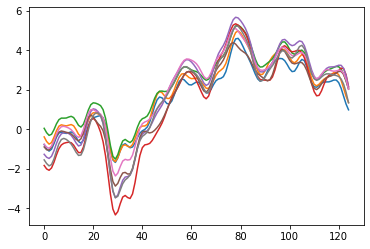

In [31]:
for col in dorsal_data.columns:
    plt.plot(bin_data[col])

In [19]:
"""
Decode from all channels
"""

cat_decode = []
for time in range(0, all_data.shape[1]):
    
    X = all_data[:,time,:]
    y = labels

    temp_acc = []
    for train_index, test_index in sss.split(X, y):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #pdb.set_trace()
        clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
        clf.fit(X_train, y_train)   

        temp_acc.append(clf.score(X_test, y_test))

    cat_decode.append(np.mean(temp_acc))



In [ ]:
timepoints = list(range(0, 500,4))
plt.plot(timepoints, cat_decode)

plt.axhline(y=0.25, color='k', linestyle='--')
plt.xlabel('time (ms)')
plt.ylabel('Accuracy (%)')

In [35]:
"""
Decode from dorsal channels
"""

cat_decode = []
for time in range(0, all_dorsal.shape[1]):
    
    X = all_dorsal[:,time,:]
    y = labels

    temp_acc = []
    for train_index, test_index in sss.split(X, y):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #pdb.set_trace()
        clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
        clf.fit(X_train, y_train)   

        temp_acc.append(clf.score(X_test, y_test))

    cat_decode.append(np.mean(temp_acc))

dorsal = cat_decode

In [36]:
"""
Decode from ventral channels
"""
cat_decode = []
for time in range(0, all_ventral.shape[1]):
    
    X = all_ventral[:,time,:]
    y = labels

    temp_acc = []
    for train_index, test_index in sss.split(X, y):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #pdb.set_trace()
        clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
        clf.fit(X_train, y_train)   

        temp_acc.append(clf.score(X_test, y_test))

    cat_decode.append(np.mean(temp_acc))

ventral = cat_decode


Text(0, 0.5, 'Accuracy (%)')

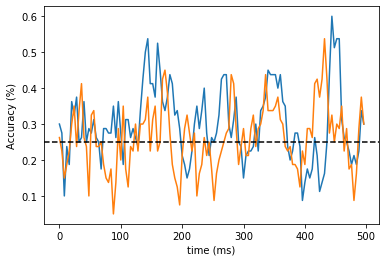

In [39]:
timepoints = list(range(0, 500,4))
plt.plot(timepoints, dorsal)
plt.plot(timepoints, ventral)
plt.axhline(y=0.25, color='k', linestyle='--')
plt.xlabel('time (ms)')
plt.ylabel('Accuracy (%)')

In [53]:
neural_ts= pd.DataFrame(columns = ['dorsal', 'ventral'])
neural_ts['dorsal'] = np.asanyarray(dorsal)[0:38] #doing it to 75 to capture stim period (i.e., 300 ms)
neural_ts['ventral'] = np.asanyarray(ventral)[0:38] #doing it to 75 to capture stim period

#calculate dorsal GCA F-test
gc_res_dorsal = grangercausalitytests(neural_ts[['ventral','dorsal']], 10, verbose=False)

#calculate ventral GCA F-test
gc_res_ventral = grangercausalitytests(neural_ts[['dorsal','ventral']], 10,verbose=False)

#calc difference
f_diff = gc_res_dorsal[1][0]['ssr_ftest'][0]-gc_res_ventral[1][0]['ssr_ftest'][0]


In [54]:
f_diff

-1.920159314008564